# Проект : Аналитика  сервиса поиска мероприятий и продажи билетов

### Описание данных
**Таблица visits (лог сервера с информацией о посещениях сайта):**  
Uid — уникальный идентификатор пользователя  
Device — категория устройства пользователя  
Start Ts — дата и время начала сессии  
End Ts — дата и время окончания сессии  
Source Id — идентификатор рекламного источника, из которого пришел пользователь  
**Таблица orders (информация о заказах):**  
Uid — уникальный id пользователя, который сделал заказ  
Buy Ts — дата и время заказа  
Revenue — выручка Яндекс.Афиши с этого заказа  
**Таблица costs (информация о затратах на маркетинг):**  
source_id — идентификатор рекламного источника  
dt — дата  
costs — затраты на этот рекламный источник в этот день  

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#импорт данных
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
#обзор данных
visits.head(5)
visits.tail(5)
visits.sample(5)





,Device,End Ts,Source Id,Start Ts,Uid
216484,touch,2017-11-12 12:02:00,4,2017-11-12 12:01:00,14900947148302743154
273216,touch,2017-06-24 14:02:00,4,2017-06-24 14:01:00,16675241986995135023
115289,desktop,2017-10-21 15:38:00,3,2017-10-21 15:32:00,10276687442434431014
33871,touch,2018-05-15 07:38:00,4,2018-05-15 07:37:00,11903251713374430181
347569,touch,2017-12-14 12:22:00,5,2017-12-14 12:02:00,1522255436323944421


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
# приведем типы данных и названия столбцов в соответствие по датасету visits
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'start ts': 'start_ts', 'end ts': 'end_ts', 'source id': 'source_id'})
visits.start_ts = pd.to_datetime(visits['start_ts'])
visits.end_ts = pd.to_datetime(visits['end_ts'])

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
#посмотрим на orders
orders.head(5)
orders.tail(5)
orders.sample(5)

,Buy Ts,Revenue,Uid
46551,2018-05-06 23:40:00,1.59,5997822398483390890
27778,2018-01-02 22:58:00,0.67,18201914511096410815
14082,2017-10-22 21:10:00,1.53,7893111783128339917
1262,2017-06-11 13:39:00,3.67,13418314325022462258
37681,2018-03-02 08:55:00,3.05,12673339288055287488


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
# приведем типы данных и названия столбцов в соответствие по датасету orders
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'buy ts': 'buy_ts'})
orders.buy_ts = pd.to_datetime(orders['buy_ts'])


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [11]:
# приведем типы данных и названия столбцов в соответствие по датасету costs
costs.dt = pd.to_datetime(costs['dt'])

In [12]:
print(visits.info())
print()
print(orders.info())
print()
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None


In [13]:
# проверим таблицы на пропуски
print(visits.isna().sum())
print()
print(orders.isna().sum())
print()
print(costs.isna().sum())

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

buy_ts     0
revenue    0
uid        0
dtype: int64

source_id    0
dt           0
costs        0
dtype: int64


In [14]:
#проверим таблицы на дубли
print(visits.duplicated().sum())
print()
print(orders.duplicated().sum())
print()
print(costs.duplicated().sum())

0

0

0


**Вывод: Мы привели типы данных в соответствующие форматы для работы: там где речь идет о времени сделали datetime64.
Проверили на пропукски и дубли - их не обнаружено. Привели к удобному для работы виду названия столбцов.**

# Шаг 2. Постройте отчёты и посчитайте метрики

Продукт  
 - Сколько людей пользуются в день, неделю, месяц?  
 - Сколько сессий в день?  
 - Сколько длится одна сессия?  
 - Как часто люди возвращаются?  

##### Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату датасета visits

In [15]:
# выделяем дату и временные отрезки
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02


In [16]:
# Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее
#mau_total - по месяцам, dau_total - по дням, wau_total - по неделям
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean().astype(int) 
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean().astype(int)
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean().astype(int)

print('Пользователей в день:',int(dau_total))
print()
print('Пользователей в неделю', int(wau_total))
print()
print('Пользоватей в месяц', int(mau_total))


Пользователей в день: 907

Пользователей в неделю 5716

Пользоватей в месяц 23228


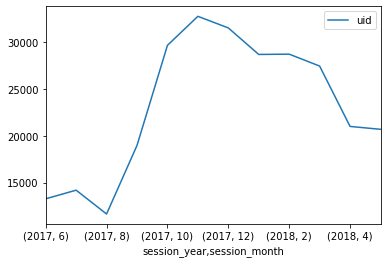

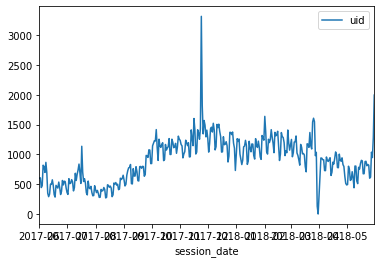

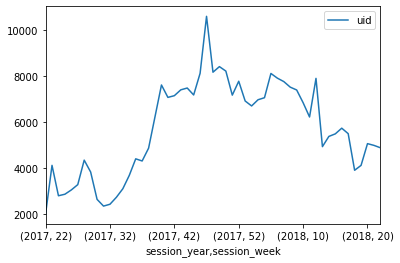

In [17]:
visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).astype(int).plot() 
visits.groupby('session_date').agg({'uid': 'nunique'}).astype(int).plot()
visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).astype(int).plot()

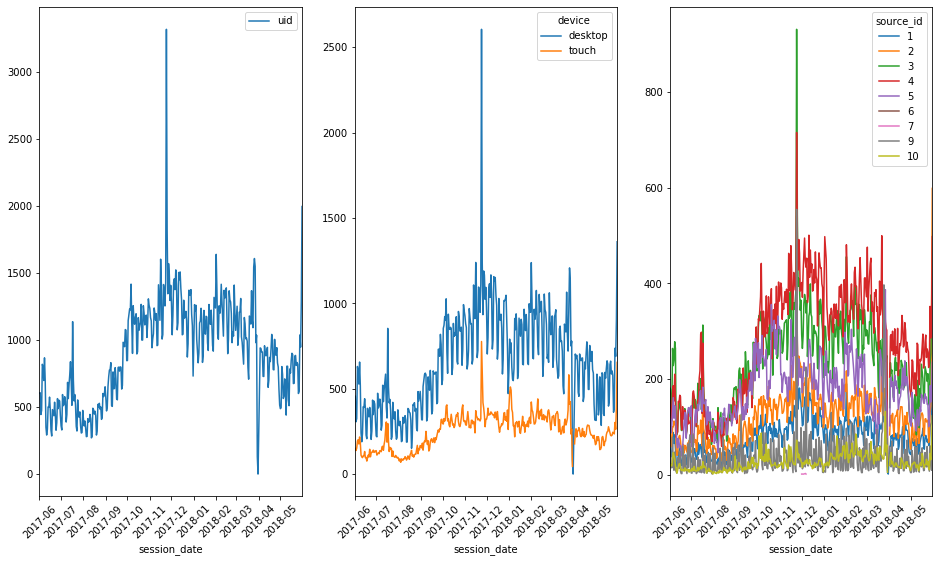

In [18]:
#посмторим на распределение по платформам и источникам
plt.subplots(figsize = (16,9))
visits.groupby(['session_date']).agg({'uid': 'nunique'}).plot(ax = plt.subplot(1,3,1))
plt.xticks(rotation = 45)
(visits.groupby(['session_date','device'])
    .agg({'uid':'nunique'})
    .pivot_table(index = 'session_date', columns = 'device', values = 'uid')
    .plot(ax = plt.subplot(1,3,2)))
plt.xticks(rotation = 45)
(visits.groupby(['session_date','source_id'])
    .agg({'uid':'nunique'})
    .pivot_table(index = 'session_date', columns = 'source_id', values = 'uid')
    .plot(ax = plt.subplot(1,3,3)))
plt.xticks(rotation = 45)
plt.show()

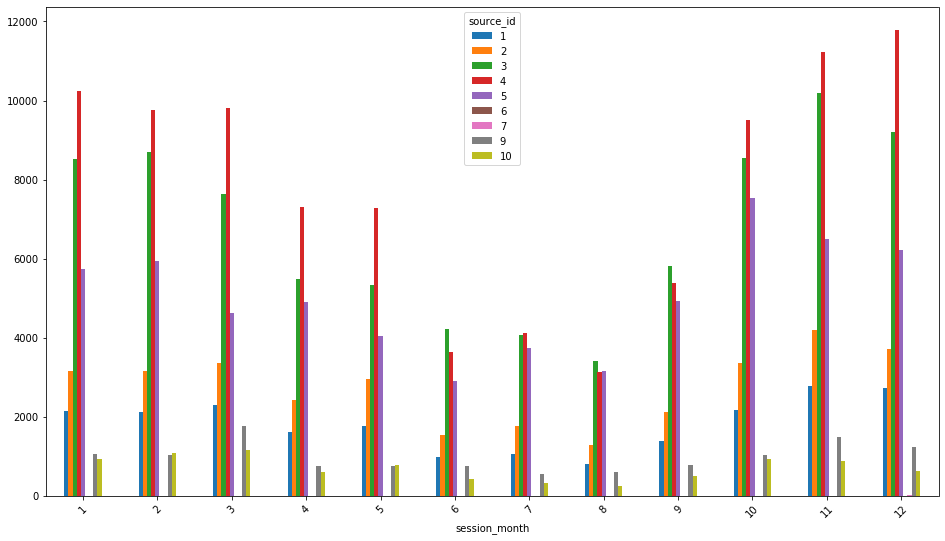

In [19]:
# рассмотрим подробнее на сессии по источникам
(visits.groupby(['session_month','source_id'])
    .agg({'uid':'nunique'})
    .pivot_table(index = 'session_month', columns = 'source_id', values = 'uid')
    .plot(kind = 'bar', figsize = (16,9))
)
plt.xticks(rotation = 45)
plt.show()

### Вывод
-  **Наибольшее количество пользователей было перед новым годом**  
-  **с desktop пользоваьелей гораздо больще**     
-  **больше всего пользователй приходило с 3 источника**


# Посчитаем сколько сессий в день:

In [20]:
#посчитаем сколько сессий и заодно сколько пользователй 
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count','nunique']})

#изменим названия столбцов на более подходящие
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user.head(10)
print('В среднем сессий в день:', sessions_per_user.n_sessions.mean())

В среднем сессий в день: 29950.0


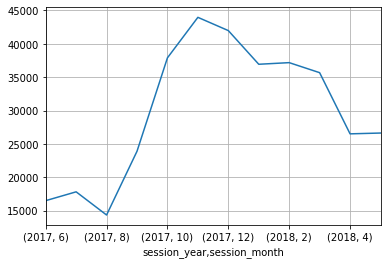

In [21]:
#взглянем на распределение количества сессий от времени
sessions_per_user.n_sessions.plot(grid = True)
plt.show()

In [22]:
#сделаем срез по платформам и посчитаем количество сессий по каждой
session_by_device = (
    visits.groupby(['session_year', 'session_month','device'])
          .agg({'uid': 'count'}).reset_index()
)
session_by_device

,session_year,session_month,device,uid
0,2017,6,desktop,12358
1,2017,6,touch,4147
2,2017,7,desktop,12950
3,2017,7,touch,4878
4,2017,8,desktop,10854
5,2017,8,touch,3501
6,2017,9,desktop,17356
7,2017,9,touch,6551
8,2017,10,desktop,27392
9,2017,10,touch,10511


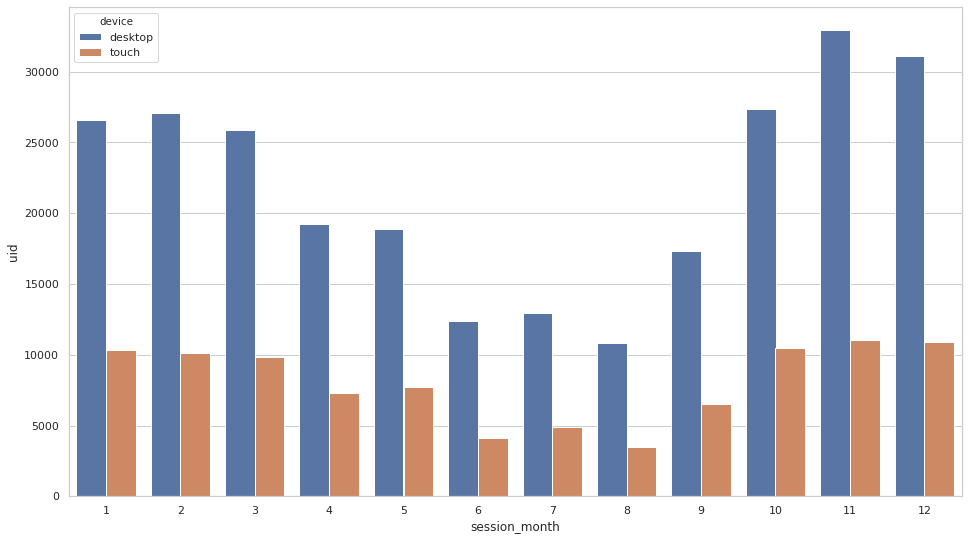

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,9))
ax = sns.barplot(x='session_month', y='uid', hue='device', data=session_by_device)


### Вывод
 - В среднем 29950 сессий в день за иследуемый приод. Но рапредление показало пик в ~44000 в декабре 2017 года, затем пошел спад. 
 - Уникальных пользователей в месяц больше всего осенье-зимой 25-35тыс, летом снижается 8-10 тыс  
 - Больше половины посещений через ПК (desktop)

##### Посчитаем сколько длится одна сессия  и ASL (Avg session length):


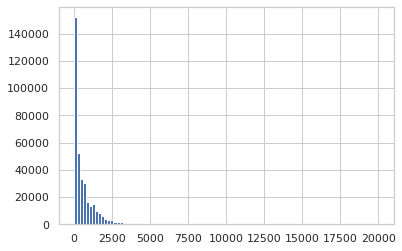

In [24]:
#Посчитаем длинну сессий как разницу между началом и завершением и построим визуализацию
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(range = (0,20000),bins=100)
plt.show()


In [25]:
#тк распределение не похоже на нормальное посчитаем наиболее часто встречающееся значение
ASL = visits.session_duration_sec.mode()
print('ASL:',int(ASL))


ASL: 60


In [26]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 10 columns):
device                  359400 non-null object
end_ts                  359400 non-null datetime64[ns]
source_id               359400 non-null int64
start_ts                359400 non-null datetime64[ns]
uid                     359400 non-null uint64
session_year            359400 non-null int64
session_month           359400 non-null int64
session_week            359400 non-null int64
session_date            359400 non-null object
session_duration_sec    359400 non-null int64
dtypes: datetime64[ns](2), int64(5), object(2), uint64(1)
memory usage: 27.4+ MB


### Вывод
ASL: 60 секунд 
Много нулевых сессии, также есть выбросы(оч долгие сессии)



##### Посчитаем как часто люди возвращаются (Retention Rate)

In [27]:
#сделаем отдельный датафрейм с необходимой информацией
user_activity = visits[['session_date','uid']]
#приведем информацию о времени в формат datatime
user_activity['session_date'] = pd.to_datetime(user_activity['session_date'])

user_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 2 columns):
session_date    359400 non-null datetime64[ns]
uid             359400 non-null uint64
dtypes: datetime64[ns](1), uint64(1)
memory usage: 5.5 MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
#выделим первое время активности и добавим его в таблицу
first_activity_date = user_activity.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_session_date'
user_activity = user_activity.merge(first_activity_date,on='uid')


In [29]:
# округлим до месяцев даты сессий
user_activity['first_session_month'] = user_activity['first_session_date'].astype('datetime64[M]')
user_activity['session_month'] = user_activity['session_date'].astype('datetime64[M]')
user_activity

,session_date,uid,first_session_date,first_session_month,session_month
0,2017-12-20,16879256277535980062,2017-12-20,2017-12-01,2017-12-01
1,2018-02-19,104060357244891740,2018-02-19,2018-02-01,2018-02-01
2,2017-07-01,7459035603376831527,2017-07-01,2017-07-01,2017-07-01
3,2018-05-20,16174680259334210214,2018-03-09,2018-03-01,2018-05-01
4,2018-03-09,16174680259334210214,2018-03-09,2018-03-01,2018-03-01
...,...,...,...,...,...
359395,2018-04-23,12734910664455613822,2018-04-23,2018-04-01,2018-04-01
359396,2017-11-08,6761309174945977743,2017-11-08,2017-11-01,2017-11-01
359397,2017-07-31,11102751930812818282,2017-07-31,2017-07-01,2017-07-01
359398,2018-03-20,272012551460639309,2018-03-20,2018-03-01,2018-03-01


In [30]:
#найдем лайфтайм когорты
user_activity['cohort_lifetime'] = user_activity['session_month'] - user_activity['first_session_month']
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')
user_activity.sample(10)

,session_date,uid,first_session_date,first_session_month,session_month,cohort_lifetime
196277,2017-09-26,14539959577670088699,2017-09-26,2017-09-01,2017-09-01,0
107477,2018-03-25,6042902810412098966,2018-02-06,2018-02-01,2018-03-01,1
279921,2018-02-02,16105632788935877023,2018-01-09,2018-01-01,2018-02-01,1
19323,2018-02-23,2335914738360522212,2018-01-20,2018-01-01,2018-02-01,1
175160,2017-12-14,12524919110210120372,2017-12-14,2017-12-01,2017-12-01,0
253694,2017-11-07,1899588219409557836,2017-11-07,2017-11-01,2017-11-01,0
149048,2017-11-17,8874569792828065758,2017-09-28,2017-09-01,2017-11-01,2
154998,2017-10-13,2982720762746719594,2017-10-13,2017-10-01,2017-10-01,0
107131,2017-10-31,13714037604952577688,2017-10-31,2017-10-01,2017-10-01,0
246884,2018-02-19,13921343450785843619,2018-01-28,2018-01-01,2018-02-01,1


In [31]:
#создадим когорты
cohorts = user_activity.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [32]:
#рассчитаем пользователей в нулевой период и добавим в таблицу
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_session_month')
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [33]:
#Рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


In [34]:
#построим сводную таблицу
retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


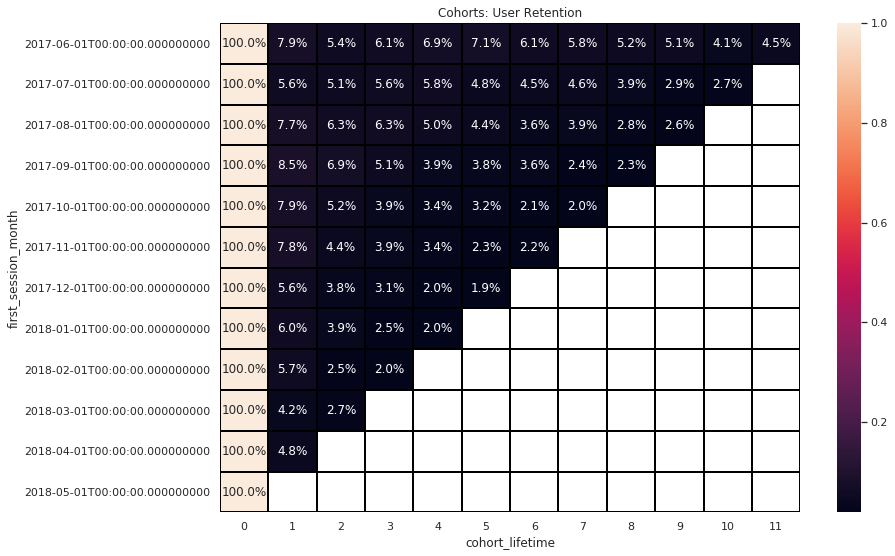

In [35]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='Black');

## Вывод


<font color='blue'>Retention Rate не болше 10 % надо что то делать) </font>



# Посчитам отчеты и метрики продаж :
 - Когда люди начинают покупать?
 - Сколько раз покупают за период?
 - Какой средний чек?
 - Сколько денег приносят? (LTV)

# Когда люди начинают покупать?



In [36]:
# создадим колонку с есяцем заказов из таблицы orders
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

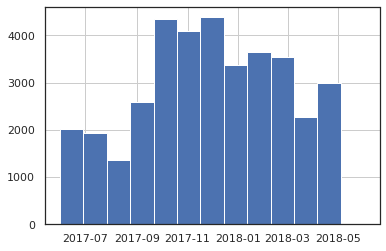

In [37]:
#выделим первые заказы 
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
# и переименуем колонки, для обхода одинаковых названий
first_orders.columns = ['uid', 'first_order_month']
first_orders.first_order_month.hist(bins = 13)
plt.show()

<Figure size 1152x648 with 0 Axes>

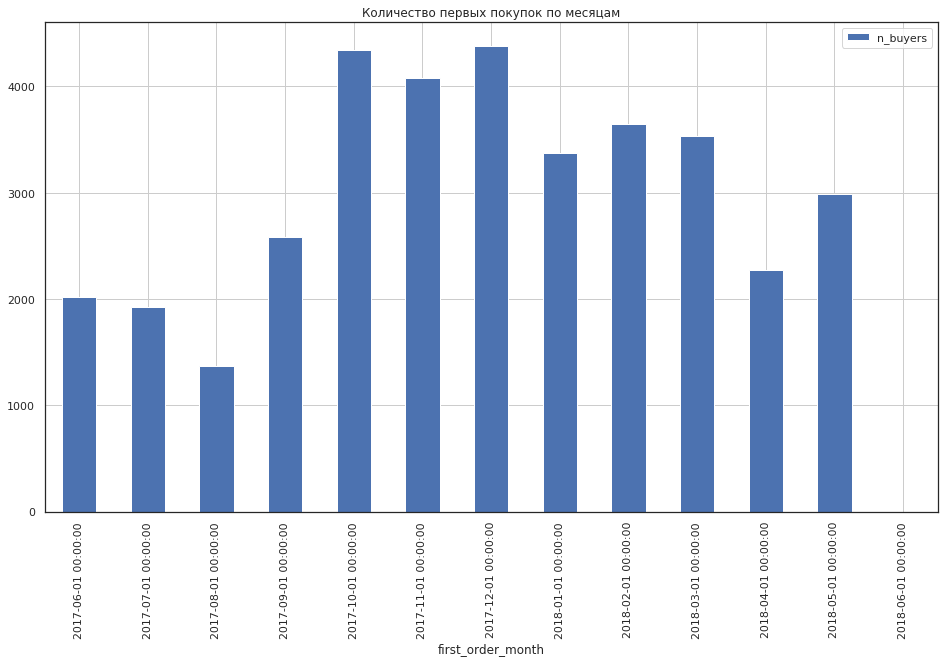

In [38]:
#посмотрим на сгруппированную таблицу, чтобы узнаь когда люди покупали впервые (размеры когорт)
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
plt.figure(figsize=(16,9))
cohort_sizes.plot(x = 'first_order_month',y='n_buyers', kind = 'bar', grid = True, figsize = (16,9) )
plt.title('Количество первых покупок по месяцам')
plt.show()


In [39]:
# первых покупок в среднем
cohort_sizes.n_buyers.mean()

2809.4615384615386

In [40]:
#выделим нужные столбцы из ордерс
ord_ = orders[['buy_ts','uid']]
ord_.head(3)
ord_group = ord_.groupby(['uid'])['buy_ts'].min()
ord_group

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: buy_ts, Length: 36523, dtype: datetime64[ns]

In [41]:
#выделим нужное из визитс
vis_ = visits[['start_ts','uid']]
vis_group = vis_.groupby(['uid'])['start_ts'].min().reset_index()
vis_group.name = 'first_visit'
vis_group

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


In [42]:
#соединим две таблицы и 
first_order = pd.merge(vis_group,ord_group,how = 'right', on = 'uid')
first_order.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 0 to 36522
Data columns (total 3 columns):
uid         36523 non-null uint64
start_ts    36523 non-null datetime64[ns]
buy_ts      36523 non-null datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 1.1 MB


In [43]:
#и посчитаем срок перед первое покупкй там где она была
first_order['time_before'] = (first_order['buy_ts'] - first_order['start_ts'])/np.timedelta64(1, 'm')

first_order.head(5)

,uid,start_ts,buy_ts,time_before
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


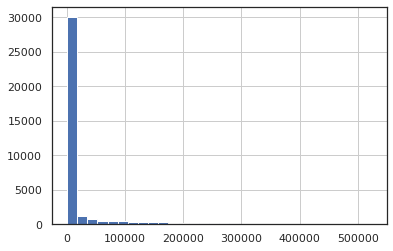

In [44]:
first_order['time_before'].hist(bins = 30)

In [45]:
#медианно покупок
first_order['time_before'].median()

16.0

In [46]:
# чаще всего покупали по вемени
first_order['time_before'].mode()

0    1.0
dtype: float64

###  Вывод
Наибольшее количество первых покупок было в Декабре, Октябре и Ноябре  
Наименьшее в Августе, Июле, Июне
Этому может быть объяснение, летом много мероприятий на природе без билетов - дача, например (:-))
В среднем первых покупок **2809** раз.

Чаще всего покупают через минуту просмотра
По медиане через 16 минут


# Посчитаем сколько раз покупают за период?

In [47]:
# обьеденим таблицы 
orders = orders.merge(first_orders, on = 'uid')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 5 columns):
buy_ts               50415 non-null datetime64[ns]
revenue              50415 non-null float64
uid                  50415 non-null uint64
order_month          50415 non-null datetime64[ns]
first_order_month    50415 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), uint64(1)
memory usage: 2.3 MB


In [48]:
#выделим месяц первой покупки и каждой покупки
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_month'].astype('datetime64[M]')


In [49]:
#объедним таблицы cohorts and orders
orders_count = orders.pivot_table(index = 'first_order_month',columns = 'order_month', values = 'buy_ts', aggfunc = 'count')
orders_count

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0,NaN
2017-07-01,NaN,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08-01,NaN,NaN,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN
2017-09-01,NaN,NaN,NaN,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,5052.0,270.0,202.0,179.0,86.0,105.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3783.0,224.0,159.0,64.0,78.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4095.0,222.0,83.0,70.0,NaN


In [50]:
visits.head(4)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440


In [51]:
#visits_count = visits.pivot_table(index)

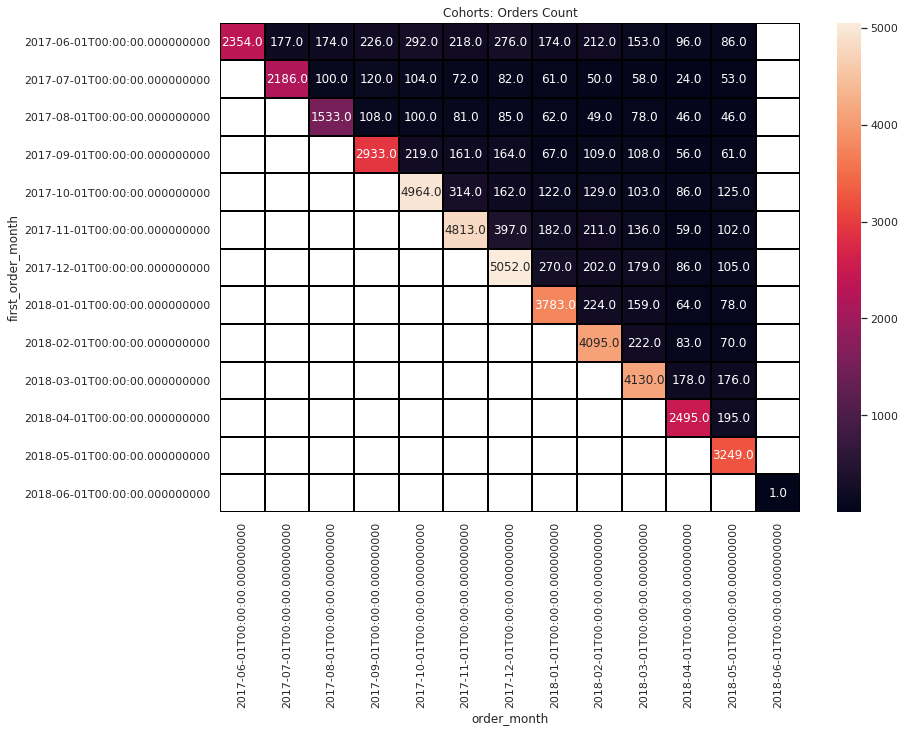

In [52]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Orders Count')
sns.heatmap(orders_count, annot=True, fmt='.1f', linewidths=1, linecolor='Black');

In [53]:
#посчитаем покупок по месяцам
orders_mean = orders.pivot_table(index = 'order_month', values = 'buy_ts', aggfunc = 'count')
orders_mean = orders_mean.rename(columns={'buy_ts':'n_orders'}).reset_index()
orders_mean

,order_month,n_orders
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


In [54]:
visits['order_month'] = visits['start_ts'].astype('datetime64[M]')

In [55]:
#посчитаем пользователей по месяцам
users_count = visits.pivot_table(index = 'order_month', values = 'uid', aggfunc = 'count')
users_count

,uid
order_month,
2017-06-01,16505
2017-07-01,17828
2017-08-01,14355
2017-09-01,23907
2017-10-01,37903
2017-11-01,43969
2017-12-01,41983
2018-01-01,36939
2018-02-01,37182


In [56]:
#   посчитаем заказов на пользователей
ord_per_uid = pd.merge(users_count, orders_mean, on = 'order_month')
ord_per_uid['ord_per_us'] = ord_per_uid['n_orders'] / ord_per_uid['uid']
ord_per_uid['ord_per_us'].mean()

0.1395902618351134

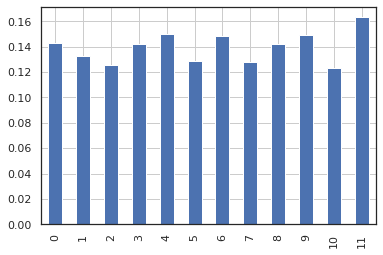

In [57]:
ord_per_uid['ord_per_us'].plot(kind = 'bar', grid = True)

In [58]:
orders_mean.n_orders.mean()

3878.076923076923

In [59]:
orders_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
order_month    13 non-null datetime64[ns]
n_orders       13 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 336.0 bytes


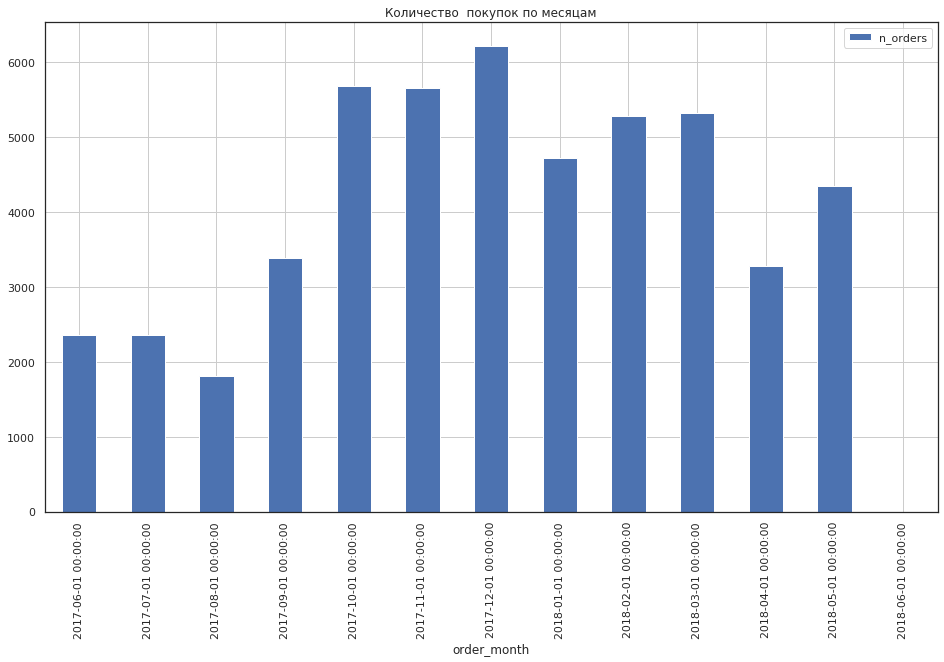

In [60]:
orders_mean.plot(x= 'order_month',y='n_orders', kind = 'bar', grid = True, figsize = (16,9) )
plt.title('Количество  покупок по месяцам')
plt.show()

### Выводы

 - Наибольшее количество паокупок было сделано в предновогодние месяцы, наименьшее в летние (совпадает с показщателями по первым покупкам)
 - Люди чаще всего делают один заказ, тк в нулевые месяцы когорт, сделаны 90% всех заказов когорты
 - В среднем в месяц сделано **3878** заказов
 - На одного пользователя приходится 0,14 заказов
  

In [61]:
orders_nunique = orders.pivot_table(index = 'first_order_month',columns = 'order_month', values = 'uid', aggfunc = ['count','nunique']).reset_index()
orders_nunique

first_order_month               count                      \
order_month                   2017-06-01 00:00:00 2017-07-01 00:00:00   
0                  2017-06-01              2354.0               177.0   
1                  2017-07-01                 NaN              2186.0   
2                  2017-08-01                 NaN                 NaN   
3                  2017-09-01                 NaN                 NaN   
4                  2017-10-01                 NaN                 NaN   
5                  2017-11-01                 NaN                 NaN   
6                  2017-12-01                 NaN                 NaN   
7                  2018-01-01                 NaN                 NaN   
8                  2018-02-01                 NaN                 NaN   
9                  2018-03-01                 NaN                 NaN   
10                 2018-04-01                 NaN                 NaN   
11                 2018-05-01                 NaN                 NaN   
12                 2018-06-01                 NaN                 NaN   

                                                                         \
order_month 2017-08-01 00:00:00 2017-09-01 00:00:00 2017-10-01 00:00:00   
0                         174.0               226.0               292.0   
1                         100.0               120.0               104.0   
2                        1533.0               108.0               100.0   
3                           NaN              2933.0               219.0   
4                           NaN                 NaN              4964.0   
5                           NaN                 NaN                 NaN   
6                           NaN                 NaN                 NaN   
7                           NaN                 NaN                 NaN   
8                           NaN                 NaN                 NaN   
9                           NaN                 NaN                 NaN   
10                          NaN                 NaN                 NaN   
11                          NaN                 NaN                 NaN   
12                          NaN                 NaN                 NaN   

                                                                         \
order_month 2017-11-01 00:00:00 2017-12-01 00:00:00 2018-01-01 00:00:00   
0                         218.0               276.0               174.0   
1                          72.0                82.0                61.0   
2                          81.0                85.0                62.0   
3                         161.0               164.0                67.0   
4                         314.0               162.0               122.0   
5                        4813.0               397.0               182.0   
6                           NaN              5052.0               270.0   
7                           NaN                 NaN              3783.0   
8                           NaN                 NaN                 NaN   
9                           NaN                 NaN                 NaN   
10                          NaN                 NaN                 NaN   
11                          NaN                 NaN                 NaN   
12                          NaN                 NaN                 NaN   

                                 ...             nunique                      \
order_month 2018-02-01 00:00:00  ... 2017-09-01 00:00:00 2017-10-01 00:00:00   
0                         212.0  ...                54.0                88.0   
1                          50.0  ...                57.0                64.0   
2                          49.0  ...                58.0                53.0   
3                         109.0  ...              2581.0               130.0   
4                         129.0  ...                 NaN              4340.0   
5                         211.0  ...                 NaN                 NaN   
6                       

# Посчитаем средний чек


In [62]:
orders

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01


In [63]:
mean_check = orders.revenue.sum()/orders.buy_ts.count()
print('Средний чек:',mean_check)

Средний чек: 4.999646930477041


In [64]:
#посчитаем средний чек по периодам икогортам

mean_check_pivot = orders.pivot_table(index = 'first_order_month',columns = 'order_month', values = 'revenue', aggfunc = 'mean')
mean_check_pivot

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.060106,5.547006,5.088161,8.545575,7.084178,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093,NaN
2017-07-01,NaN,5.287123,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,NaN,NaN,4.715479,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN
2017-09-01,NaN,NaN,NaN,4.967109,13.171187,8.351056,62.570244,15.430448,15.321835,16.767130,11.206607,7.785574,NaN
2017-10-01,NaN,NaN,NaN,NaN,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.370717,4.103955,4.474670,6.284976,4.441471,3.726780,4.598235,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.110746,4.226741,20.072772,26.084358,15.948488,14.111048,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687417,4.438482,6.454969,7.524844,2.711282,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.706266,4.576486,3.453735,3.867143,NaN


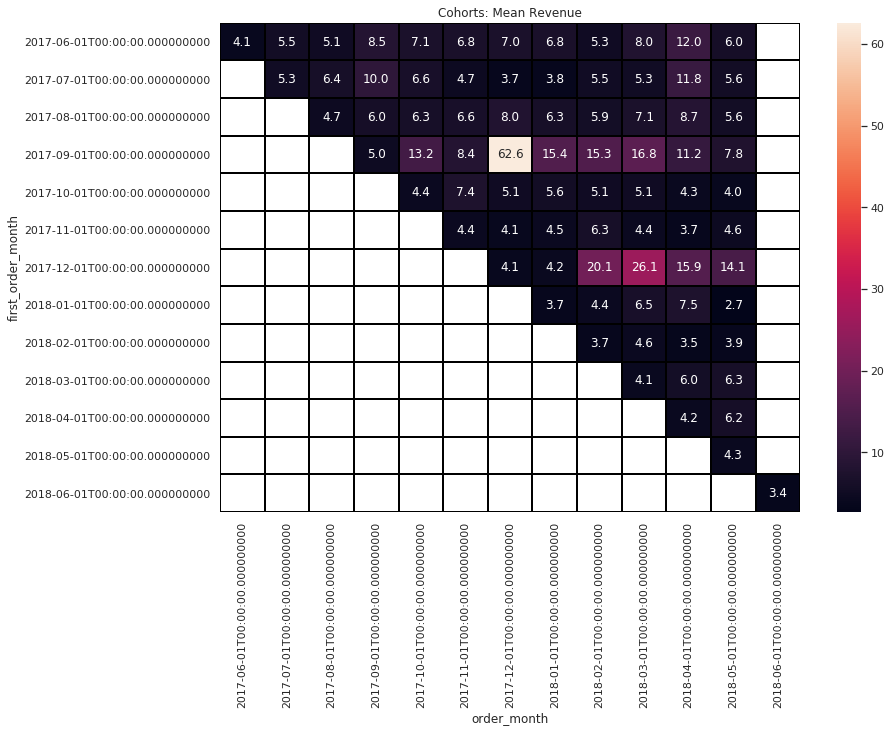

In [65]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Mean Revenue')
sns.heatmap(mean_check_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='Black');

In [66]:
# сформируем чек по месяцам
month_mean_check = orders.pivot_table(index = 'order_month', values = 'revenue', aggfunc = 'mean').reset_index()
month_mean_check

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280
5,2017-11-01,4.783518
6,2017-12-01,5.852139
7,2018-01-01,4.112927
8,2018-02-01,4.840095
9,2018-03-01,5.413930


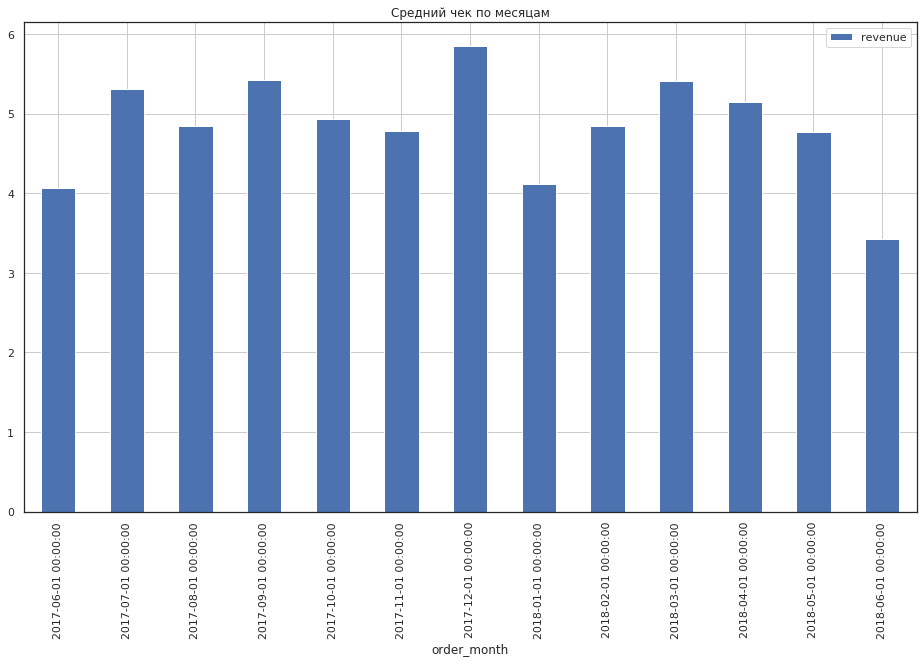

In [67]:
# и взглянем на средний по периодам
month_mean_check.plot(x= 'order_month',y='revenue', kind = 'bar', grid = True, figsize = (16,9) )
plt.title('Средний чек по месяцам')
plt.show()

### Вывод
 - средний чек равен **5** 
 - самый высокий средний чек ожидаемо в декабре, затем сентябрь (соскучились по мероприятиям после лета) и в марте ( 8 марта как никак)
 - у сентябрьской и декабрьской когорты чеки выше
 - повышенный среднйи чек в декабре сформировн засчет аномально дорогих покупок в сентябрьской когорте
 


# Расчет LTV

In [68]:
orders

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01


In [69]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа
cohorts_new = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_new

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [70]:
report = pd.merge(cohort_sizes, cohorts_new, on='first_order_month')
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


In [71]:
#посчитаем возраст когорты
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4
...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,0


In [72]:
#посчитаем LTV
report['ltv'] = report['revenue'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,0,4.660562


In [73]:
#сделаем пивот табле для расчетов
ltv_pivot = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')


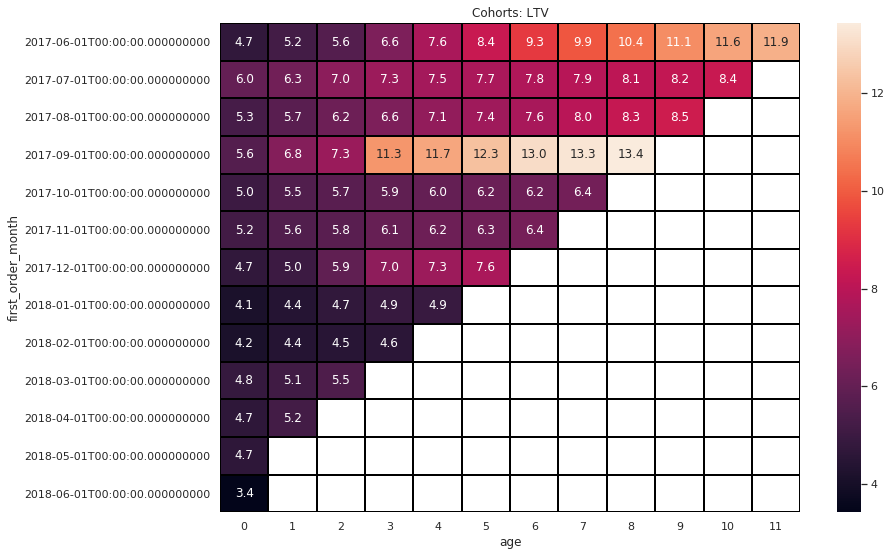

In [74]:
#создадим тепловю карту и посчитаем LTV клиентов в когорте по наростающей
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='Black');

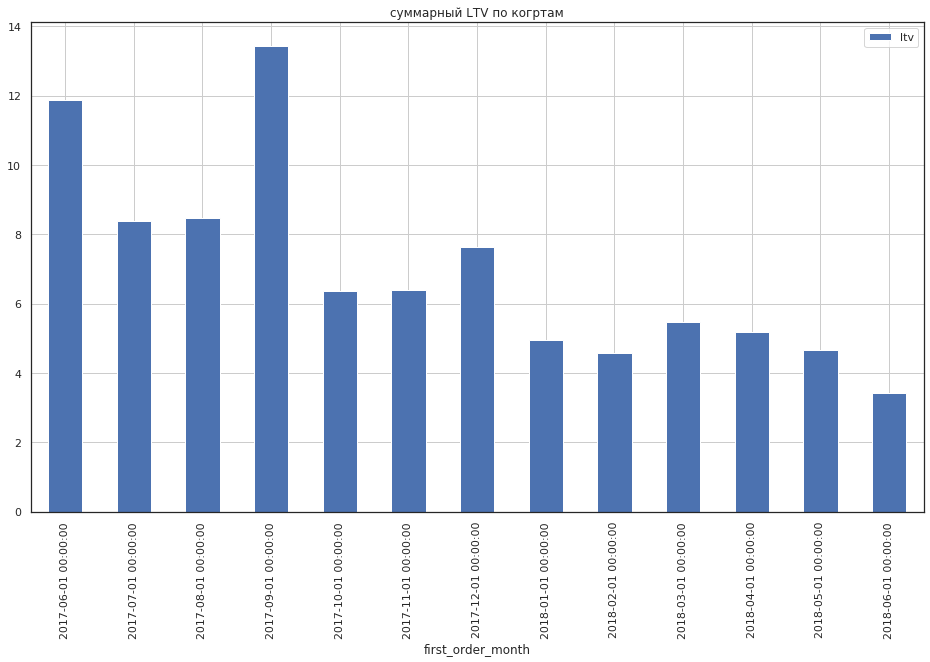

In [75]:
#посчитаем LTV по когортам
cohorts_ltv = report.pivot_table(
        index='first_order_month', 
        values='ltv', 
        aggfunc='sum').reset_index()

cohorts_ltv.plot(x= 'first_order_month',y='ltv', kind = 'bar', grid = True, figsize = (16,9) )
plt.title('суммарный LTV по когртам')
plt.show()

In [76]:
cohorts_ltv

,first_order_month,ltv
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


### Выводы:

 - Июльская и сентябрьская когорта cамые доходные
 - подтверждаются прошлые выводы о заказах только в 0 месяц, так именно они формируют основной показатель LTV по lifetime value когорт.
 


# Маркетинг
### Сколько денег потратили? Всего / на каждый источник / по времени  
### Сколько стоило привлечение одного покупателя из каждого источника?  
### На сколько окупились расходы? (ROI)  

In [77]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [78]:
# построим таблицу с затратми на источники по месяцам
costs_pivot = costs.pivot_table(index = 'source_id', columns = 'dt_month', values = 'costs', aggfunc = 'sum')
costs_pivot

dt_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


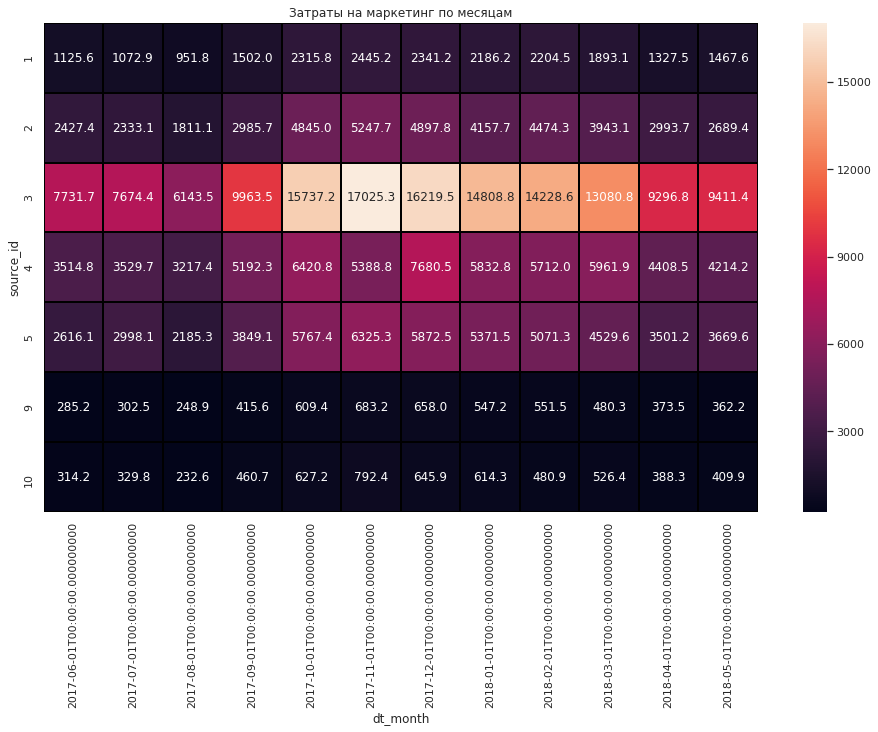

In [79]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Затраты на маркетинг по месяцам')
sns.heatmap(costs_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='Black');

In [80]:
#потратили денег всего
total_costs = costs['costs'].sum()
total_costs

329131.62

In [81]:
costs_by_source = costs.pivot_table(index = 'source_id',  values = 'costs', aggfunc = 'sum')
costs_by_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


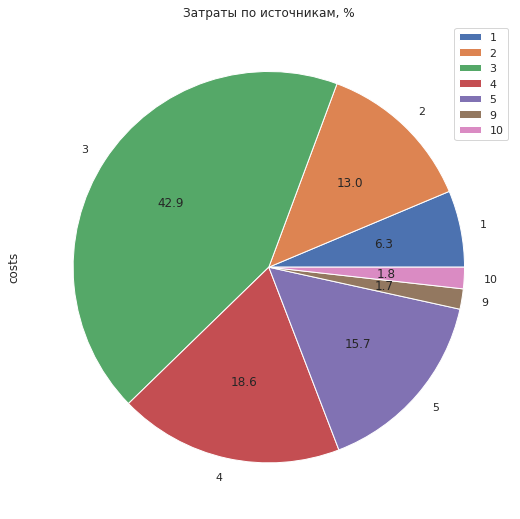

In [82]:
# построим диаграмму распределения затрат по источникам
costs_by_source.plot(y='costs', kind = 'pie', autopct='%.1f',  figsize = (20,9) )
plt.title('Затраты по источникам, %')
plt.show()

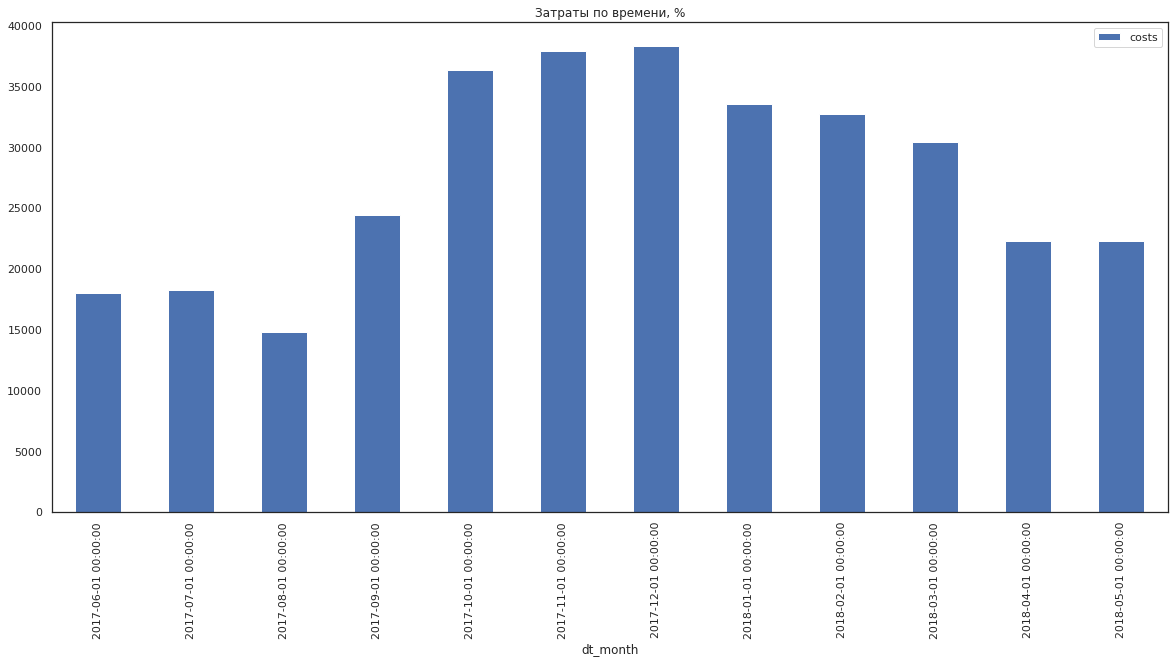

In [83]:
# и такую же по времени
costs_by_month = costs.pivot_table(index = 'dt_month',  values = 'costs', aggfunc = 'sum').reset_index() 
   
costs_by_month.plot(x= 'dt_month',y='costs', kind = 'bar',   figsize = (20,9) )
plt.title('Затраты по времени, %')
plt.show()

### Выводы
 - всего потрачено **329131.62** уе.
 - по источникам больше всего потрачено на 3,4 и 5
 - по времени (ожидаемо) в предновогодние месяцы
 - больше всего было потрачено в ноябре, декабре, октябре из третьего источника
 


### Сколько стоило привлечение одного покупателя из каждого источника(CAC)?

Сделаем расчет САС по когортам. Соедним таблицы costs_by_month и report. 

In [84]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 11 columns):
device                  359400 non-null object
end_ts                  359400 non-null datetime64[ns]
source_id               359400 non-null int64
start_ts                359400 non-null datetime64[ns]
uid                     359400 non-null uint64
session_year            359400 non-null int64
session_month           359400 non-null int64
session_week            359400 non-null int64
session_date            359400 non-null object
session_duration_sec    359400 non-null int64
order_month             359400 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(2), uint64(1)
memory usage: 30.2+ MB


In [85]:
#выводим все uid с источником и первм месяцем
first_source = visits.pivot_table(index = ['uid','source_id', 'device'], values = 'session_date', aggfunc = 'min').reset_index()
first_source['session_month'] = first_source['session_date'].astype('datetime64[M]')
first_source

,uid,source_id,device,session_date,session_month
0,11863502262781,3,touch,2018-03-01,2018-03-01
1,49537067089222,2,touch,2018-02-06,2018-02-01
2,297729379853735,3,desktop,2017-06-07,2017-06-01
3,313578113262317,2,desktop,2017-09-18,2017-09-01
4,325320750514679,5,desktop,2017-09-30,2017-09-01
...,...,...,...,...,...
282160,18446403737806311543,5,desktop,2017-11-30,2017-11-01
282161,18446424184725333426,4,touch,2017-12-06,2017-12-01
282162,18446556406699109058,3,touch,2018-01-01,2018-01-01
282163,18446621818809592527,4,desktop,2017-12-27,2017-12-01


In [86]:
# считаем количетсво клиентов оп месяцам из источников
count_source = first_source.pivot_table(index = ['source_id','device'], columns = 'session_month', values = 'uid', aggfunc = 'count')
count_source

session_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop       705.0       677.0       492.0       852.0      1353.0   
          touch         271.0       304.0       195.0       407.0       627.0   
2         desktop      1120.0      1123.0       772.0      1251.0      1925.0   
          touch         430.0       489.0       272.0       553.0       925.0   
3         desktop      3343.0      3059.0      2542.0      4153.0      6189.0   
          touch         906.0       941.0       739.0      1459.0      2021.0   
4         desktop      2510.0      2600.0      1959.0      3317.0      5855.0   
          touch        1144.0      1412.0       988.0      1772.0      3164.0   
5         desktop      2084.0      2565.0      2288.0      3375.0      5254.0   
          touch         823.0      1107.0       782.0      1422.0      2045.0   
6         desktop         NaN         1.0         NaN         1.0         NaN   
          touch           NaN         NaN         1.0         NaN         NaN   
7         desktop         1.0         2.0         1.0         3.0         3.0   
          touch           1.0         NaN         NaN         NaN         2.0   
9         desktop       580.0       396.0       407.0       507.0       673.0   
          touch         178.0       119.0       117.0       145.0       197.0   
10        desktop       306.0       228.0       178.0       351.0       697.0   
          touch         124.0        81.0        63.0       141.0       217.0   

session_month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id device                                                                
1         desktop      1853.0      1683.0      1217.0      1195.0      1304.0   
          touch         674.0       711.0       633.0       635.0       640.0   
2         desktop      2468.0      1996.0      1560.0      1588.0      1722.0   
          touch        1044.0       932.0       871.0       852.0       840.0   
3         desktop      7554.0      6600.0      5806.0      5932.0      5167.0   
          touch        2122.0      2021.0      2076.0      2072.0      1764.0   
4         desktop      7008.0      7243.0      5851.0      5561.0      5673.0   
          touch        3374.0      3437.0      3297.0      3026.0      2954.0   
5         desktop      4732.0      4511.0      4039.0      4123.0      3161.0   
          touch        1474.0      1353.0      1366.0      1443.0      1142.0   
6         desktop         1.0         1.0         1.0         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
7         desktop         1.0         8.0         3.0         2.0         1.0   
          touch           NaN         1.0         1.0         1.0         NaN   
9         desktop       929.0       719.0       595.0       576.0       956.0   
          touch         323.0       219.0       203.0       190.0       436.0   
10        desktop       660.0       416.0       587.0       735.0       734.0   
          touch         201.0       167.0       289.0       299.0       387.0   

session_month      2018-04-01  2018-05-01  
source_id device                           
1         desktop       908.0       933.0  
          touch         454.0       543.0  
2         desktop      1201.0      1531.0  
          touch         595.0       806.0  
3         desktop      3644.0      3431.0  
          touch        1237.0      1242.0  
4         desktop      4069.0      3961.0  
          touch        2333.0      2412.0  
5         desktop      3305.0      2616.0  
          touch        1294.0      1124.0  
6         desktop         NaN         NaN  
          touch           NaN         NaN  
7         desktop         NaN         1.0  
          touch           1.0         1.0  
9         desktop       346.0       395.0  
          

In [87]:
costs_pivot

dt_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


In [88]:
#посчитаем затраты на привлечение каждого пользователя по месяцам
cost_by_client = costs_pivot/count_source
cost_by_client

dt_month           2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop    1.596610    1.584756    1.934573    1.762923    1.711567   
          touch      4.153542    3.529211    4.881077    3.690442    3.693381   
2         desktop    2.167304    2.077569    2.345920    2.386619    2.516883   
          touch      5.645070    4.771186    6.658272    5.399024    5.237838   
3         desktop    2.312788    2.508784    2.416814    2.399121    2.542776   
          touch      8.533830    8.155547    8.313315    6.829027    7.786858   
4         desktop    1.400319    1.357588    1.642348    1.565348    1.096642   
          touch      3.072378    2.499809    3.256437    2.930169    2.029343   
5         desktop    1.255336    1.168865    0.955105    1.140486    1.097716   
          touch      3.178761    2.708347    2.794476    2.706850    2.820244   
6         desktop         NaN         NaN         NaN         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
7         desktop         NaN         NaN         NaN         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
9         desktop    0.491759    0.763990    0.611622    0.819763    0.905513   
          touch      1.602360    2.542353    2.127607    2.866345    3.093452   
10        desktop    1.026863    1.446579    1.306573    1.312450    0.899914   
          touch      2.534032    4.071852    3.691587    3.267163    2.890507   

dt_month           2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id device                                                                
1         desktop    1.319568    1.391087    1.796368    1.844753    1.451756   
          touch      3.627834    3.292827    3.453681    3.471622    2.957953   
2         desktop    2.126288    2.453808    2.665218    2.817594    2.289861   
          touch      5.026513    5.255150    4.773525    5.251573    4.694214   
3         desktop    2.253818    2.457503    2.550599    2.398611    2.531614   
          touch      8.023252    8.025492    7.133324    6.867066    7.415448   
4         desktop    0.768953    1.060399    0.996888    1.027146    1.050920   
          touch      1.597161    2.234644    1.769120    1.887627    2.018236   
5         desktop    1.336716    1.301822    1.329913    1.230005    1.432971   
          touch      4.291275    4.340370    3.932299    3.514421    3.966392   
6         desktop         NaN         NaN         NaN         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
7         desktop         NaN         NaN         NaN         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
9         desktop    0.735393    0.915132    0.919597    0.957465    0.502395   
          touch      2.115108    3.004475    2.695369    2.902632    1.101583   
10        desktop    1.200545    1.552548    1.046593    0.654259    0.717180   
          touch      3.942090    3.867425    2.125779    1.608294    1.360233   

dt_month           2018-04-01  2018-05-01  
source_id device                           
1         desktop    1.461993    1.573001  
          touch      2.923987    2.702781  
2         desktop    2.492673    1.756656  
          touch      5.031429    3.336774  
3         desktop    2.551265    2.743055  
          touch      7.515610    7.577633  
4         desktop    1.083433    1.063926  
          touch      1.889623    1.747185  
5         desktop    1.059349    1.402737  
          touch      2.705680    3.264733  
6         desktop         NaN         NaN  
          touch           NaN         NaN  
7         desktop         NaN         NaN  
          touch           NaN         NaN  
9         desktop    1.079451    0.916886  
          

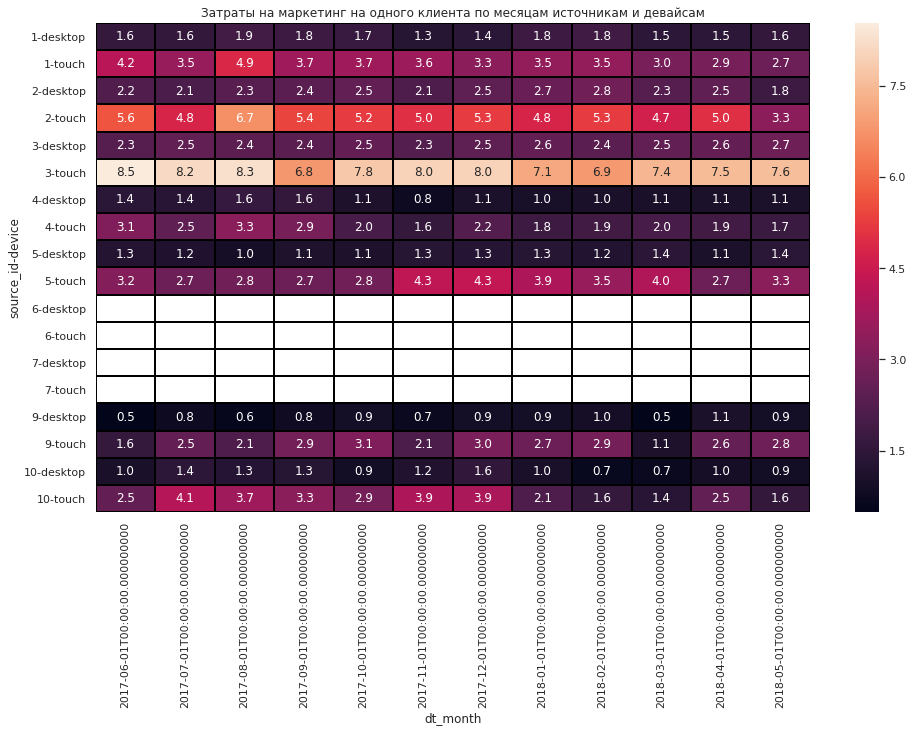

In [89]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Затраты на маркетинг на одного клиента по месяцам источникам и девайсам')
sns.heatmap(cost_by_client, annot=True, fmt='.1f', linewidths=1, linecolor='Black');

По данной тепловой карте видно, что по крупным источникам, оч больщая цена клиента со мобильных устройств

In [90]:
# взглянем на затраты по источникам и девайсам
df_cac = cost_by_client.sum(axis = 1).reset_index()
df_cac.columns =['source_id', 'device', 'sum']
df_cac

,source_id,device,sum
0,1,desktop,19.428956
1,1,touch,42.378338
2,2,desktop,28.096392
3,2,touch,61.080567
4,3,desktop,29.666747
5,3,touch,92.176402
6,4,desktop,14.113910
7,4,touch,26.931731
8,5,desktop,14.711022
9,5,touch,40.223848


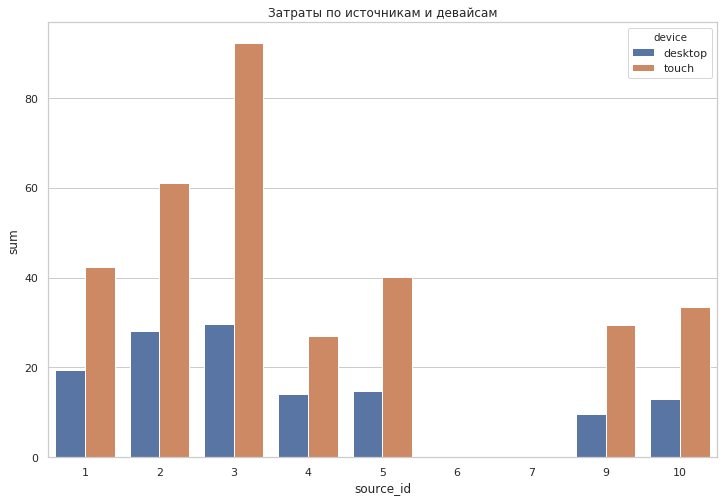

In [91]:
#взглянем визуально
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.set(style="whitegrid")
ax = sns.barplot(x="source_id", y="sum", hue="device", data=df_cac).set_title('Затраты по источникам и девайсам')


**Расчет затрат по месяцам**

In [92]:
report = pd.merge(report, costs_by_month, left_on='order_month', right_on='dt_month', how='inner').drop('dt_month', axis=1)

In [93]:
report['cac'] = report['costs'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18240.59,9.016604
2,2017-07-01,1923,2017-07-01,11557.65,0,6.010218,18240.59,9.485486
3,2017-06-01,2023,2017-08-01,885.34,2,0.437637,14790.54,7.311191
4,2017-07-01,1923,2017-08-01,644.61,1,0.335211,14790.54,7.691388
...,...,...,...,...,...,...,...,...
73,2018-01-01,3373,2018-05-01,211.48,4,0.062698,22224.27,6.588873
74,2018-02-01,3651,2018-05-01,270.70,3,0.074144,22224.27,6.087173
75,2018-03-01,3533,2018-05-01,1114.87,2,0.315559,22224.27,6.290481
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599,22224.27,9.764618


In [94]:
#сделаем пивот табле для расчетов
cac_pivot = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='cac', 
        aggfunc='mean')
cac_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,8.905091,9.016604,7.311191,12.045927,17.954958,18.738448,18.939867,16.568720,16.175497,15.034736,11.017983,10.985798
2017-07-01,9.485486,7.691388,12.672340,18.888653,19.712886,19.924779,17.430328,17.016656,15.816573,11.590941,11.557083,NaN
2017-08-01,10.796015,17.787526,26.513051,27.669985,27.967409,24.466073,23.885423,22.200927,16.269620,16.222095,NaN,NaN
2017-09-01,9.441654,14.073181,14.687284,14.845157,12.986641,12.678431,11.784297,8.635947,8.610721,NaN,NaN,NaN
2017-10-01,8.369327,8.734535,8.828422,7.723161,7.539869,7.008127,5.135802,5.120800,NaN,NaN,NaN,NaN
2017-11-01,9.288870,9.388716,8.213310,8.018385,7.452896,5.461745,5.445790,NaN,NaN,NaN,NaN,NaN
2017-12-01,8.741809,7.647392,7.465898,6.939373,5.085416,5.070561,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,9.937302,9.701462,9.017275,6.608177,6.588873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,8.962758,8.330668,6.105007,6.087173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


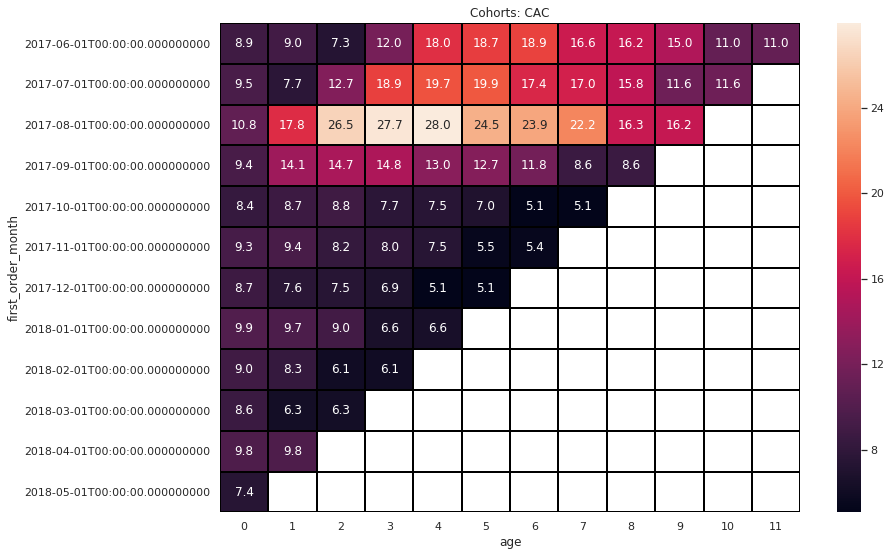

In [95]:
#создадим тепловю карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: CAC')
sns.heatmap(cac_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='Black');

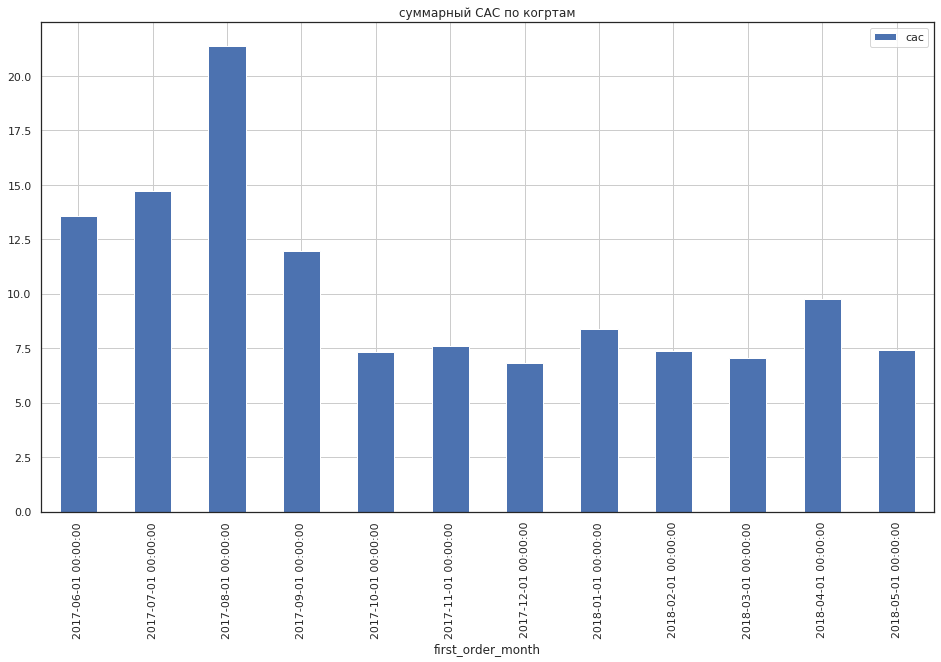

In [96]:
#посчитаем CAC по когортам
cohorts_cac = report.pivot_table(
        index='first_order_month', 
        values='cac', 
        aggfunc='mean').reset_index()

cohorts_cac.plot(x= 'first_order_month',y='cac', kind = 'bar', grid = True, figsize = (16,9) )
plt.title('суммарный CAC по когртам')
plt.show()

### Вывод
 - самая затратная августовская когорта
 - в летние месяцы много потрачено
 - в декбре на августовскую когорте самый высокий CAC
 - зимние когоры имеют средний сас
 
 
  

# На сколько окупились расходы? (ROI

In [97]:
report['roi'] = report['ltv'] / report['cac']

In [98]:
report

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac,roi
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.00,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18240.59,9.016604,0.053826
2,2017-07-01,1923,2017-07-01,11557.65,0,6.010218,18240.59,9.485486,0.633623
3,2017-06-01,2023,2017-08-01,885.34,2,0.437637,14790.54,7.311191,0.059859
4,2017-07-01,1923,2017-08-01,644.61,1,0.335211,14790.54,7.691388,0.043583
...,...,...,...,...,...,...,...,...,...
73,2018-01-01,3373,2018-05-01,211.48,4,0.062698,22224.27,6.588873,0.009516
74,2018-02-01,3651,2018-05-01,270.70,3,0.074144,22224.27,6.087173,0.012180
75,2018-03-01,3533,2018-05-01,1114.87,2,0.315559,22224.27,6.290481,0.050165
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599,22224.27,9.764618,0.054441


In [99]:
roi_pivot = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')
roi_pivot = roi_pivot.cumsum(axis=1).round(2)

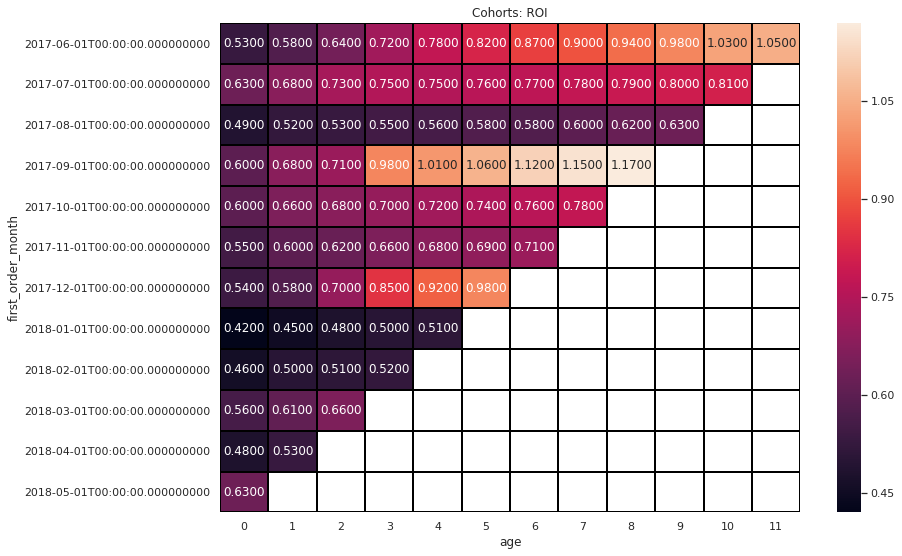

In [100]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: ROI')
sns.heatmap(roi_pivot, annot=True, fmt='.4f', linewidths=1, linecolor='Black');

In [101]:
#Посчитаем среднюю ROI для средних когорт. 
roi_pivot.mean(axis=0)

age
0     0.540833
1     0.580909
2     0.626000
3     0.692222
4     0.741250
5     0.804286
6     0.801667
7     0.842000
8     0.880000
9     0.803333
10    0.920000
11    1.050000
dtype: float64

### Вывод 
 - В среднем Затраты окупаеются через год
 - сентябрьская когорта окупилась быстрее всего
 - вообще окупились только июньская, сентябрьская и почти декабрьская


### считаем ROI по источникам

In [102]:
#ищем источник юзера
source_device = first_source.groupby(['source_id','device'])['uid'].agg({'uid':'nunique'}).reset_index()
source_device.column = ['source_id', 'device', 'n_uid']
source_device

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


,source_id,device,uid
0,1,desktop,13172
1,1,touch,6094
2,2,desktop,18257
3,2,touch,8609
4,3,desktop,57420
5,3,touch,18600
6,4,desktop,55607
7,4,touch,29313
8,5,desktop,42053
9,5,touch,15375


In [103]:
source_orders = orders.merge(first_source, how = 'left', on = 'uid')
source_orders.head(1)

,buy_ts,revenue,uid,order_month,first_order_month,source_id,device,session_date,session_month
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,1,desktop,2017-06-01,2017-06-01


In [104]:
#фиксируем месяц прибытия на платформу
first_month = source_orders.groupby(['uid'])['session_date'].min()
first_month.name = 'first_month'
source_orders = source_orders.merge(first_month,on='uid')
source_orders['first_month'] = source_orders['first_month'].astype('datetime64[M]')
source_orders.head(1)

,buy_ts,revenue,uid,order_month,first_order_month,source_id,device,session_date,session_month,first_month
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,1,desktop,2017-06-01,2017-06-01,2017-06-01


In [105]:
#делаем сводную таблицу для расчетов LTV
first_source = first_source.merge(first_month,on='uid')
first_source['first_month'] = first_source['first_month'].astype('datetime64[M]')
first_source['age'] = (first_source['session_month'] - first_source['first_month']) / np.timedelta64(1, 'M')
first_source['age'] = first_source['age'].round().astype('int')
first_source

,uid,source_id,device,session_date,session_month,first_month,age
0,313578113262317,2,desktop,2017-09-18,2017-09-01,2017-09-01,0
1,1575281904278712,10,touch,2017-06-03,2017-06-01,2017-06-01,0
2,2429014661409475,3,desktop,2017-10-11,2017-10-01,2017-10-01,0
3,2464366381792757,5,desktop,2018-01-27,2018-01-01,2018-01-01,0
4,2551852515556206,5,desktop,2017-11-24,2017-11-01,2017-11-01,0
...,...,...,...,...,...,...,...
59168,18446156210226471712,1,touch,2018-02-19,2018-02-01,2017-11-01,3
59169,18446156210226471712,3,desktop,2017-11-07,2017-11-01,2017-11-01,0
59170,18446156210226471712,4,desktop,2017-11-07,2017-11-01,2017-11-01,0
59171,18446156210226471712,5,desktop,2018-02-14,2018-02-01,2017-11-01,3


In [106]:
source_orders['age'] = (source_orders['session_month'] - source_orders['first_month']) / np.timedelta64(1, 'M')
source_orders['age'] = source_orders['age'].round().astype('int')
dfsource_orders = source_orders.query('session_month  < "2017-12-01" ')
dfsource_orders

,buy_ts,revenue,uid,order_month,first_order_month,source_id,device,session_date,session_month,first_month,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,desktop,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2,desktop,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2,desktop,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2,desktop,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3,desktop,2017-06-01,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...,...,...,...
105086,2018-05-31 22:11:00,0.30,10999828041850243290,2018-05-01,2018-05-01,4,desktop,2017-07-04,2017-07-01,2017-07-01,0
105088,2018-05-31 22:16:00,7.33,9985845906947650101,2018-05-01,2018-05-01,5,desktop,2017-09-20,2017-09-01,2017-09-01,0
105089,2018-05-31 22:16:00,7.33,9985845906947650101,2018-05-01,2018-05-01,5,touch,2017-09-20,2017-09-01,2017-09-01,0
105120,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01,3,desktop,2017-10-23,2017-10-01,2017-10-01,0


In [107]:
#считаем сумму пользователей
source_orders_month_sum = dfsource_orders.pivot_table(index = ['source_id','device'], columns = 'session_month', values = 'revenue', aggfunc = 'sum')

source_orders_month_sum

session_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop    17373.72     6269.29     4604.55     7651.79     7670.58   
          touch        636.92      959.82     1848.76      626.22     4506.67   
2         desktop    17093.66     7993.06     5157.50     6925.24     9184.60   
          touch       2298.48     1624.11      999.02     2983.71     4631.15   
3         desktop     7634.41     8097.69     5707.23     8541.35    12512.23   
          touch        745.11     1107.38      679.83     3658.11     1455.35   
4         desktop    12994.49     7075.71     5102.64     6709.34    11241.75   
          touch       2679.62     1616.31     1486.61     2145.64     3319.18   
5         desktop     9571.60     9242.11     5543.94    18874.52    10296.03   
          touch        831.85     1055.84      537.82     1554.17     1965.66   
7         desktop         NaN         NaN        1.22         NaN         NaN   
9         desktop     1061.93      891.04      881.72     2693.02     1352.43   
          touch        147.74      197.23      195.88      173.75      244.58   
10        desktop      542.61     1007.08      274.99      306.74      656.42   
          touch         81.60       47.93      121.57       61.91      140.30   

session_month      2017-11-01  
source_id device               
1         desktop     8630.16  
          touch       3586.04  
2         desktop    20156.43  
          touch       3167.03  
3         desktop    10897.37  
          touch       3485.91  
4         desktop    10234.61  
          touch       4108.01  
5         desktop     7925.78  
          touch        876.44  
7         desktop         NaN  
9         desktop     1713.68  
          touch        504.72  
10        desktop      836.39  
          touch        625.15

In [108]:
#считаем кол-во пользователей
source_orders_month_count = dfsource_orders.pivot_table(index = ['source_id','device'], columns = 'session_month', values = 'uid', aggfunc = 'count')
source_orders_month_count

session_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop      2128.0       833.0       495.0       921.0      1217.0   
          touch         146.0       165.0       160.0       181.0       362.0   
2         desktop      1911.0      1240.0       656.0       973.0      1323.0   
          touch         251.0       229.0       148.0       274.0       474.0   
3         desktop      1487.0      1474.0       816.0      1557.0      2309.0   
          touch         235.0       250.0       138.0       591.0       396.0   
4         desktop      1591.0      1262.0       970.0      1160.0      2128.0   
          touch         296.0       342.0       200.0       329.0       647.0   
5         desktop      1657.0      1204.0       913.0      1355.0      1738.0   
          touch         169.0       232.0       158.0       278.0       369.0   
7         desktop         NaN         NaN         1.0         NaN         NaN   
9         desktop       307.0       198.0       244.0       428.0       353.0   
          touch          46.0        54.0        69.0        54.0        66.0   
10        desktop       152.0       126.0        76.0       121.0       272.0   
          touch          40.0        19.0        26.0        26.0        64.0   

session_month      2017-11-01  
source_id device               
1         desktop      1545.0  
          touch         472.0  
2         desktop      1786.0  
          touch         427.0  
3         desktop      2188.0  
          touch         549.0  
4         desktop      2368.0  
          touch         756.0  
5         desktop      1348.0  
          touch         235.0  
7         desktop         NaN  
9         desktop       557.0  
          touch         164.0  
10        desktop       225.0  
          touch          88.0

In [109]:
df_ltv = source_orders_month_sum / source_orders_month_count

In [110]:
#LTV по устройствам и источникам
df_ltv = df_ltv.cumsum(axis = 1)
df_ltv 


session_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop    8.164342   15.690501   24.992622   33.300754   39.603614   
          touch      4.362466   10.179557   21.734307   25.194086   37.643450   
2         desktop    8.944877   15.390893   23.252936   30.370346   37.312598   
          touch      9.157291   16.249474   22.999609   33.889062   43.659421   
3         desktop    5.134102   10.627786   17.621940   23.107714   28.526610   
          touch      3.170681    7.600201   12.526505   18.716201   22.391327   
4         desktop    8.167498   13.774242   19.034695   24.818609   30.101386   
          touch      9.052770   13.778823   21.211873   27.733575   32.863683   
5         desktop    5.776463   13.452635   19.524858   33.454393   39.378461   
          touch      4.922189    9.473224   12.877148   18.467687   23.794679   
7         desktop         NaN         NaN    1.220000         NaN         NaN   
9         desktop    3.459055    7.959257   11.572864   17.864967   21.696213   
          touch      3.211739    6.864147    9.702987   12.920580   16.626337   
10        desktop    3.569803   11.562501   15.180791   17.715832   20.129141   
          touch      2.040000    4.562632    9.238401   11.619555   13.811742   

session_month      2017-11-01  
source_id device               
1         desktop   45.189478  
          touch     45.240993  
2         desktop   48.598393  
          touch     51.076353  
3         desktop   33.507126  
          touch     28.740890  
4         desktop   34.423434  
          touch     38.297559  
5         desktop   45.258120  
          touch     27.524211  
7         desktop         NaN  
9         desktop   24.772838  
          touch     19.703898  
10        desktop   23.846430  
          touch     20.915719

In [111]:
costs = costs.rename(columns = {'dt' : 'acquisition_date'})
costs.head(2)

,source_id,acquisition_date,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


In [112]:
#строим профили юзеров (acquisition - приобретение)
users = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
               .rename(columns = {'start_ts' : 'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]') 
users = (users.reset_index()
              .set_index(['source_id', 'acquisition_date'])
              .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))

users

uid      acquisition_ts   device  \
source_id acquisition_date                                                      
1         2017-06-01          469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01          618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01         1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01         1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01         1548840741623289234 2017-06-01 01:18:00  desktop   
...                                          ...                 ...      ...   
10        2018-05-31        17550479715346067160 2018-05-31 22:00:00    touch   
          2018-05-31        17715613363403416471 2018-05-31 03:30:00  desktop   
          2018-05-31        18076428844159112818 2018-05-31 17:47:00    touch   
          2018-05-31        18238279803055794091 2018-05-31 15:52:00    touch   
          2018-05-31        18428797902626915731 2018-05-31 22:10:00  desktop   

                           acquisition_month  costs   dt_month  
source_id acquisition_date                                      
1         2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
...                                      ...    ...        ...  
10        2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  

[228169 rows x 6 columns]

In [113]:
#добавляем стоимость приобретения индивидуального пользователя
user_cost = (users.groupby(['source_id', 'acquisition_date'])
                  .agg({'device': 'count', 'costs': 'max'})
                  .rename(columns = {'device': 'users'}))
user_cost['acqusition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acqusition_cost']], how = 'left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                                'source_id', 'device', 'acqusition_cost']]
users.head(1)

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acqusition_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6


In [114]:
# обрежем время до полугода, чтобы убрать из расчета "умирающих пользователей"
users = users.query('acquisition_month < "2017-12-01" ')

In [115]:
# посчитаем сас по источникам
df_cac = users.pivot_table(index = ['source_id','device'], columns = 'acquisition_month', values = 'acqusition_cost', aggfunc = 'sum')
df_cac

acquisition_month   2017-06-01   2017-07-01   2017-08-01   2017-09-01  \
source_id device                                                        
1         desktop   794.370006   743.298428   684.451032  1017.868489   
          touch     331.239994   329.581572   267.358968   484.141511   
2         desktop  1751.850103  1606.665770  1292.086640  1999.264066   
          touch     675.529897   726.444230   518.963360   986.395934   
3         desktop  6060.562802  5868.796971  4740.207819  7303.726484   
          touch    1671.087198  1805.573029  1403.332181  2659.823516   
4         desktop  2380.606977  2314.619450  2091.232696  3374.486378   
          touch    1134.193023  1215.110550  1126.127304  1817.773622   
5         desktop  1911.579099  2103.446958  1625.864518  2706.396805   
          touch     704.540901   894.693042   559.415482  1142.743195   
6         desktop          NaN     0.000000          NaN          NaN   
7         desktop     0.000000     0.000000     0.000000     0.000000   
          touch       0.000000          NaN          NaN          NaN   
9         desktop   211.569445   210.618415   192.138038   331.581271   
          touch      73.650555    82.141585    56.791962    75.488729   
10        desktop   221.055107   244.827066   178.756682   329.551424   
          touch      93.164893    84.992934    52.443318   131.118576   

acquisition_month    2017-10-01    2017-11-01  
source_id device                               
1         desktop   1561.720976   1781.229419  
          touch      754.029024    663.930581  
2         desktop   3224.576346   3632.307345  
          touch     1620.423654   1615.372655  
3         desktop  11843.890612  13400.644623  
          touch     3893.349388   3624.695377  
4         desktop   4094.862260   3545.562099  
          touch     2325.977740   1843.257901  
5         desktop   4163.120970   4802.092792  
          touch     1604.279030   1523.247208  
6         desktop           NaN      0.000000  
7         desktop      0.000000      0.000000  
          touch        0.000000           NaN  
9         desktop    470.483211    474.353493  
          touch      138.926789    208.826507  
10        desktop    463.048483    587.870742  
          touch      164.191517    204.489258

In [117]:
#посчитаем roi
df_roi = df_ltv/df_cac
df_roi

session_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id device                                                                
1         desktop    0.010278    0.021109    0.036515    0.032716    0.025359   
          touch      0.013170    0.030886    0.081293    0.052039    0.049923   
2         desktop    0.005106    0.009579    0.017996    0.015191    0.011571   
          touch      0.013556    0.022369    0.044318    0.034356    0.026943   
3         desktop    0.000847    0.001811    0.003718    0.003164    0.002409   
          touch      0.001897    0.004209    0.008926    0.007037    0.005751   
4         desktop    0.003431    0.005951    0.009102    0.007355    0.007351   
          touch      0.007982    0.011340    0.018836    0.015257    0.014129   
5         desktop    0.003022    0.006396    0.012009    0.012361    0.009459   
          touch      0.006986    0.010588    0.023019    0.016161    0.014832   
6         desktop         NaN         NaN         NaN         NaN         NaN   
7         desktop         NaN         NaN         inf         NaN         NaN   
          touch           NaN         NaN         NaN         NaN         NaN   
9         desktop    0.016350    0.037790    0.060232    0.053878    0.046115   
          touch      0.043608    0.083565    0.170851    0.171159    0.119677   
10        desktop    0.016149    0.047227    0.084924    0.053757    0.043471   
          touch      0.021897    0.053682    0.176160    0.088619    0.084120   

session_month      2017-11-01  
source_id device               
1         desktop    0.025370  
          touch      0.068141  
2         desktop    0.013379  
          touch      0.031619  
3         desktop    0.002500  
          touch      0.007929  
4         desktop    0.009709  
          touch      0.020777  
5         desktop    0.009425  
          touch      0.018069  
6         desktop         NaN  
7         desktop         NaN  
          touch           NaN  
9         desktop    0.052224  
          touch      0.094355  
10        desktop    0.040564  
          touch      0.102283

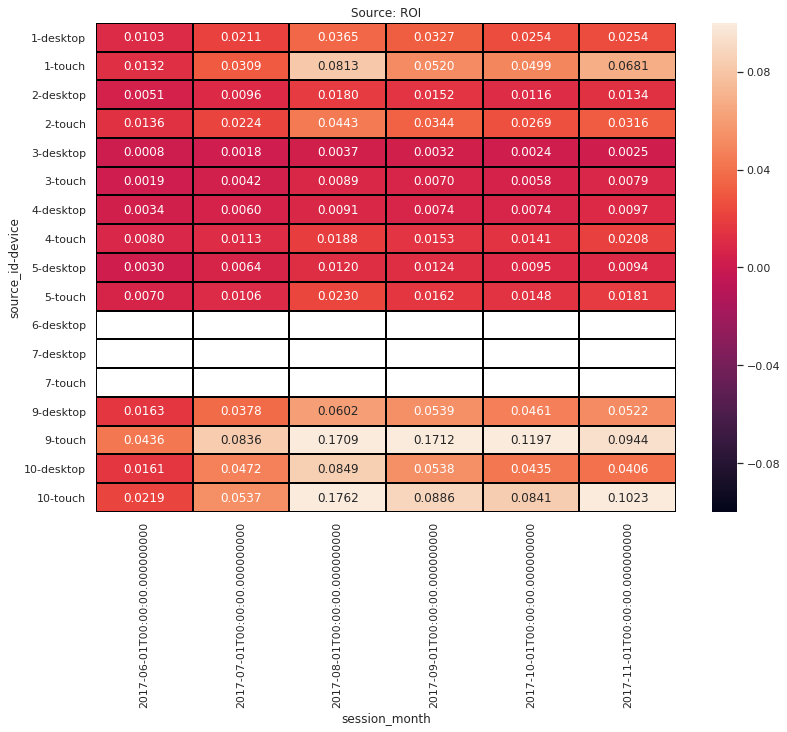

In [118]:
# построим хитмэп
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source: ROI')
sns.heatmap(df_roi, annot=True, fmt='.4f', linewidths=1, linecolor='Black');

# Общие выводы 

Главные
1. Затраты на маркетинг с мобильных устройств крайне не эффективны
2. Необходимо повышать Retention Rate
3. За первые полгода данных, самые эффективные источники получились 9-touch, 10-touch,1-touch,9-desktop
4. Средний ROI 12 месяцев
5. Очень низкий интерес летом (возможно связано с малым кол-вом мероприятий и другой мотивацие людей)
6. Только три когорты за год смогли окупиться, необходимо пересмотреть затраты на маркетиногвые источники см п 1 и 3
7. 14% вссех пользователей делают покупки, это очень мало, нужно принимать меры!!


Остальные
Пользователей в день: 907

Пользователей в неделю 5716

Пользоватей в месяц 23228

Вывод
Наибольшее количество пользователей было перед новым годом
с desktop пользоваьелей гораздо больще
больше всего пользователй приходило с 3 источника

В среднем 29950 сессий в день за иследуемый приод. Но рапредление показало пик в ~44000 в декабре 2017 года, затем пошел спад.
Уникальных пользователей в месяц больше всего осенье-зимой 25-35тыс, летом снижается 8-10 тыс
Больше половины посещений через ПК (desktop)

ASL: 60 секунд Много нулевых сессии, также есть выбросы(оч долгие сессии)

Retention Rate не болше 10 % надо что то делать)

Вывод по первым покупкам
Наибольшее количество первых покупок было в Декабре, Октябре и Ноябре
Наименьшее в Августе, Июле, Июне Этому может быть объяснение, летом много мероприятий на природе без билетов - дача, например (:-)) В среднем первых покупок 2809 раз.

Чаще всего покупают через минуту просмотра.
По медиане через 16 минут

Выводы по покупкам
Наибольшее количество паокупок было сделано в предновогодние месяцы, наименьшее в летние (совпадает с показщателями по первым покупкам)
Люди чаще всего делают один заказ, тк в нулевые месяцы когорт, сделаны 90% всех заказов когорты
В среднем в месяц сделано 3878 заказов
На одного пользователя приходится 0,14 заказов


Вывод по среднему чеку
средний чек равен 5
самый высокий средний чек ожидаемо в декабре, затем сентябрь (соскучились по мероприятиям после лета) и в марте ( 8 марта как никак)
у сентябрьской и декабрьской когорты чеки выше
повышенный среднйи чек в декабре сформировн засчет аномально дорогих покупок в сентябрьской когорте

Выводы по LTV:
Июльская и сентябрьская когорта cамые доходные
подтверждаются прошлые выводы о заказах только в 0 месяц, так именно они формируют основной показатель LTV по lifetime value когорт.

Выводы по маркетингу
всего потрачено 329131.62 уе.
по источникам больше всего потрачено на 3,4 и 5
по времени (ожидаемо) в предновогодние месяцы
больше всего было потрачено в ноябре, декабре, октябре из третьего источника



Вывод по затратам
самая затратная августовская когорта
в летние месяцы много потрачено
в декбре на августовскую когорте самый высокий CAC
зимние когоры имеют средний сас

Вывод по ROI
В среднем Затраты окупаеются через год
сентябрьская когорта окупилась быстрее всего
вообще окупились только июньская, сентябрьская и почти декабрьская